<a href="https://colab.research.google.com/github/l1kemood/Demo/blob/main/mnist_%E6%9C%80%E7%BB%88%E7%89%88%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
from torch import nn,optim
from torch.autograd import Variable
from torchvision import datasets,transforms # Corrected the module name from 'torchvison' to 'torchvision'
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt


In [16]:
train_dataset=datasets.MNIST(root='./data',train=True,transform=transforms.ToTensor(),download=True)
test_dataset=datasets.MNIST(root='./data',train=False,transform=transforms.ToTensor())

In [17]:
#Batch size
batch_size=64
#Loaded in the training set
train_loader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
#Loaded in the testing set
test_loader=DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

In [6]:
for i,data in enumerate(train_loader):
  inputs,labels=data
  print(inputs.shape)
  print(labels.shape)
  break

torch.Size([64, 1, 28, 28])
torch.Size([64])


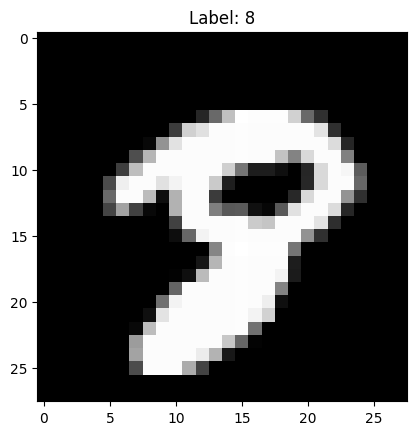

In [ ]:
for i, data in enumerate(train_loader):
  inputs, labels = data
  break

plt.imshow(inputs[0].squeeze(), cmap='gray')
plt.title(f"Label: {labels[0]}")
plt.show()

In [18]:
#Define network structure
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = nn.Sequential(nn.Conv2d(1,32,5,1,2),nn.ReLU(),nn.MaxPool2d(2,2))
    self.conv2 = nn.Sequential(nn.Conv2d(32,64,5,1,2),nn.ReLU(),nn.MaxPool2d(2,2))
    self.fc1 = nn.Sequential(nn.Linear(64*7*7,1000),nn.Dropout(p=0.5),nn.ReLU())
    self.fc2 = nn.Sequential(nn.Linear(1000,10),nn.Softmax(dim=1))

  def forward(self,x):
    # [64, 1, 28, 28]
    x = self.conv1(x)
    x = self.conv2(x)
    #(64,64,7,7)
    x = x.view(x.size()[0],-1)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [19]:
#注意力模块
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attn = self.conv1(x)
        attn = self.sigmoid(attn)
        return x * attn  # 将注意力权重应用于输入特征

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1,32,5,1,2),nn.ReLU(),nn.MaxPool2d(2,2))
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, 5, 1, 2), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.attention = SpatialAttention(64)  # 添加注意力模块
        self.fc1 = nn.Sequential(nn.Linear(64 * 7 * 7, 1000), nn.Dropout(p=0.5), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(1000,10),nn.Softmax(dim=1))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention(x)  # 应用注意力模块
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [5]:
#残差链接
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        #self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1,32,5,1,2),nn.ReLU(),nn.MaxPool2d(2,2))
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, 5, 1, 2), nn.ReLU(), nn.MaxPool2d(2, 2))
        # 这里添加残差块，输入输出通道数与conv2相同
        self.res_block = ResidualBlock(64, 64)
        #self.attention = SpatialAttention(64)
        self.fc1 = nn.Sequential(nn.Linear(64 * 7 * 7, 1000), nn.Dropout(p=0.5), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(1000,10),nn.Softmax(dim=1))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # 应用残差块
        x = self.res_block(x)
        #x = self.attention(x)
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [21]:
LR = 0.0003
#Define the model
model = Net()
#Define cost function
mse_loss = nn.CrossEntropyLoss()
#Define optimizer,Set L2 regularization
optimizer = optim.Adam(model.parameters(),LR)

In [22]:
# Initialize lists to store accuracy for each epoch
train_acc_list = []
test_acc_list = []

def train():
    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        out = model(inputs)
        loss = mse_loss(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test():
    model.eval()
    correct = 0
    for i, data in enumerate(test_loader):
        inputs, labels = data
        out = model(inputs)
        _, predicted = torch.max(out, 1)
        correct += (predicted == labels).sum()

    test_acc = correct.item() / len(test_dataset)
    test_acc_list.append(test_acc)
    print("Test acc: {0}".format(test_acc))

    correct = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        out = model(inputs)
        _, predicted = torch.max(out, 1)
        correct += (predicted == labels).sum()

    train_acc = correct.item() / len(train_dataset)
    train_acc_list.append(train_acc)
    print("Train acc: {0}".format(train_acc))

In [13]:

# Initialize lists to store losses for each epoch
train_loss_list = []  # 用于存储训练损失
test_loss_list = []  # 用于存储测试损失

def train():
    model.train()
    total_loss = 0  # 累积每个 epoch 的训练损失
    for i, data in enumerate(train_loader):
        inputs, labels = data
        out = model(inputs)
        loss = mse_loss(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()  # 累积损失

    avg_train_loss = total_loss / len(train_loader)  # 计算平均训练损失
    train_loss_list.append(avg_train_loss)  # 将平均训练损失添加到列表中
    print("Train Loss: {0}".format(avg_train_loss))  # 打印训练损失

def test():
    model.eval()
    correct = 0
    total_loss = 0  # 累积测试损失
    with torch.no_grad():  # 在测试模式下不需要计算梯度
        for i, data in enumerate(test_loader):
            inputs, labels = data
            out = model(inputs)
            loss = mse_loss(out, labels)  # 计算测试损失
            total_loss += loss.item()  # 累积损失
            _, predicted = torch.max(out, 1)
            correct += (predicted == labels).sum()

    avg_test_loss = total_loss / len(test_loader)  # 计算平均测试损失
    test_loss_list.append(avg_test_loss)  # 将平均测试损失添加到列表中
    print("Test Loss: {0}".format(avg_test_loss))  # 打印测试损失

    test_acc = correct.item() / len(test_dataset)
    test_acc_list.append(test_acc)
    print("Test acc: {0}".format(test_acc))

    correct = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        out = model(inputs)
        _, predicted = torch.max(out, 1)
        correct += (predicted == labels).sum()

    train_acc = correct.item() / len(train_dataset)
    train_acc_list.append(train_acc)
    print("Train acc: {0}".format(train_acc))



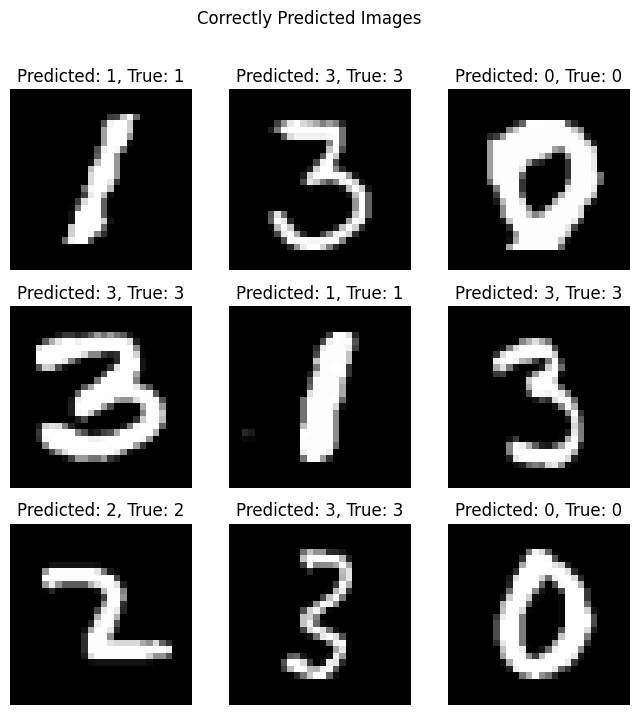

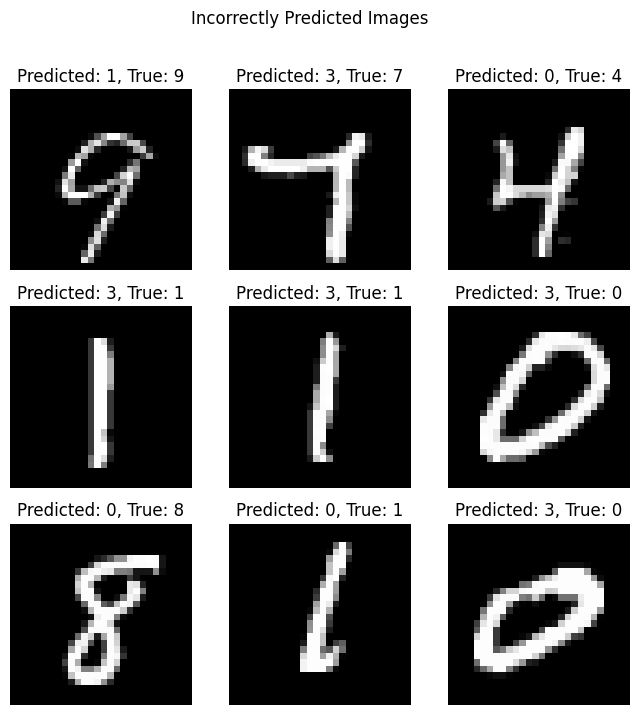

In [7]:
# 获取预测结果和对应的图像数据
predictions = []
true_labels = []
all_images = []
for i, data in enumerate(train_loader):
    inputs, labels = data
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    predictions.extend(predicted.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())
    all_images.extend(inputs.cpu().numpy())

# 筛选预测结果
correct_indices = np.where(np.array(predictions) == np.array(true_labels))[0]
incorrect_indices = np.where(np.array(predictions) != np.array(true_labels))[0]

# 可视化预测结果
# 准确预测的图像
plt.figure(figsize=(8, 8))
for i, index in enumerate(correct_indices[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(all_images[index].squeeze(), cmap='gray') # 使用 all_images[index] 获取图像
    plt.title(f"Predicted: {predictions[index]}, True: {true_labels[index]}")
    plt.axis('off')
plt.suptitle("Correctly Predicted Images")
plt.show()

# 预测失败的图像
plt.figure(figsize=(8, 8))
for i, index in enumerate(incorrect_indices[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(all_images[index].squeeze(), cmap='gray') # 使用 all_images[index] 获取图像
    plt.title(f"Predicted: {predictions[index]}, True: {true_labels[index]}")
    plt.axis('off')
plt.suptitle("Incorrectly Predicted Images")
plt.show()

In [ ]:
#不要运行，不要运行，不要运行
#正常使用CNN
#使用dorpout,测试状态不适用dropput
#使用adam优化器代替sgd优化器
#在优化器中添加L2正则化代码
for epoch in range(20):
  print('epoch:',epoch)
  train()
  test()

epoch: 0
Test acc:0.9766
Train acc:0.9749666666666666
epoch: 1
Test acc:0.9831
Train acc:0.98385
epoch: 2
Test acc:0.9803
Train acc:0.97955
epoch: 3
Test acc:0.9817
Train acc:0.9836
epoch: 4
Test acc:0.99
Train acc:0.9907166666666667
epoch: 5
Test acc:0.9894
Train acc:0.9901
epoch: 6
Test acc:0.989
Train acc:0.9906166666666667
epoch: 7
Test acc:0.99
Train acc:0.9907666666666667
epoch: 8
Test acc:0.9866
Train acc:0.98905
epoch: 9
Test acc:0.9844
Train acc:0.9866666666666667
epoch: 10
Test acc:0.9879
Train acc:0.988
epoch: 11
Test acc:0.9888
Train acc:0.9894
epoch: 12
Test acc:0.9913
Train acc:0.9930333333333333
epoch: 13
Test acc:0.9882
Train acc:0.9908333333333333
epoch: 14
Test acc:0.9917
Train acc:0.99265
epoch: 15
Test acc:0.9871
Train acc:0.9899666666666667
epoch: 16
Test acc:0.9901
Train acc:0.9917
epoch: 17
Test acc:0.9877
Train acc:0.9887
epoch: 18
Test acc:0.9867
Train acc:0.9899666666666667
epoch: 19
Test acc:0.9901
Train acc:0.9913833333333333


In [12]:
#简化模型
#Reduce the number of layers of the network or the number of neurons per layer
#将全连接层的神经元数量从 1000 减少到 500

for epoch in range(30):
  print('epoch:',epoch)
  train()
  test()

epoch: 0
Test acc: 0.9883
Train acc: 0.9886166666666667
epoch: 1
Test acc: 0.9879
Train acc: 0.99035
epoch: 2
Test acc: 0.9892
Train acc: 0.9903333333333333
epoch: 3
Test acc: 0.9877
Train acc: 0.9885166666666667
epoch: 4
Test acc: 0.9886
Train acc: 0.9897166666666667
epoch: 5
Test acc: 0.9885
Train acc: 0.9900833333333333
epoch: 6
Test acc: 0.9893
Train acc: 0.9912
epoch: 7
Test acc: 0.989
Train acc: 0.9907666666666667
epoch: 8
Test acc: 0.9901
Train acc: 0.9917833333333334
epoch: 9
Test acc: 0.9898
Train acc: 0.9918666666666667
epoch: 10
Test acc: 0.9844
Train acc: 0.9877833333333333
epoch: 11
Test acc: 0.9881
Train acc: 0.9921333333333333
epoch: 12
Test acc: 0.9881
Train acc: 0.9915833333333334
epoch: 13
Test acc: 0.9885
Train acc: 0.9908666666666667
epoch: 14
Test acc: 0.9889
Train acc: 0.9928166666666667
epoch: 15
Test acc: 0.9883
Train acc: 0.9915
epoch: 16
Test acc: 0.9878
Train acc: 0.9904666666666667
epoch: 17
Test acc: 0.989
Train acc: 0.9911166666666666
epoch: 18
Test acc: 0

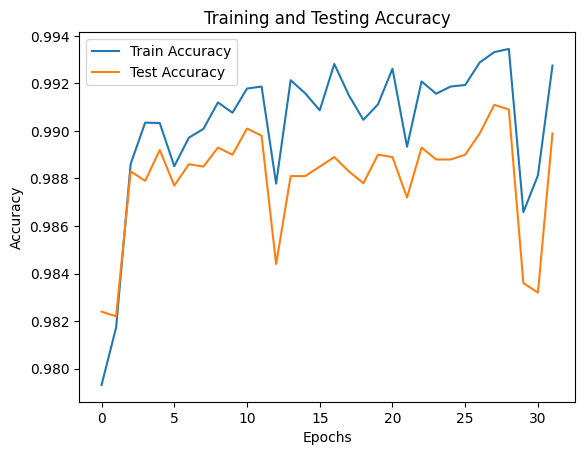

In [18]:
# Visualize the accuracy over epochs
plt.plot(range(32), train_acc_list, label='Train Accuracy')
plt.plot(range(32), test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy')
plt.show()

In [ ]:
#调整学习率从0.001缩小为0.0003
for epoch in range(10):
  print('epoch:',epoch)
  train()
  test()

epoch: 0
Test acc:0.9712
Train acc:0.96995
epoch: 1
Test acc:0.9802
Train acc:0.97815
epoch: 2
Test acc:0.9828
Train acc:0.9832166666666666
epoch: 3
Test acc:0.9843
Train acc:0.9857
epoch: 4
Test acc:0.9877
Train acc:0.9903833333333333
epoch: 5
Test acc:0.9884
Train acc:0.99125
epoch: 6
Test acc:0.9904
Train acc:0.9928833333333333
epoch: 7
Test acc:0.9887
Train acc:0.9923333333333333
epoch: 8
Test acc:0.9904
Train acc:0.9933666666666666
epoch: 9
Test acc:0.9909
Train acc:0.99325


In [ ]:
#添加注意力模块
for epoch in range(10):
  print('epoch:',epoch)
  train()
  test()

epoch: 0
Test acc:0.9686
Train acc:0.9658666666666667
epoch: 1
Test acc:0.9776
Train acc:0.9762666666666666
epoch: 2
Test acc:0.9841
Train acc:0.9845166666666667
epoch: 3
Test acc:0.9863
Train acc:0.9867333333333334
epoch: 4
Test acc:0.9852
Train acc:0.9867
epoch: 5
Test acc:0.9893
Train acc:0.9900833333333333
epoch: 6
Test acc:0.9894
Train acc:0.9913666666666666
epoch: 7
Test acc:0.9904
Train acc:0.9920166666666667
epoch: 8
Test acc:0.99
Train acc:0.9924166666666666
epoch: 9
Test acc:0.9913
Train acc:0.9940666666666667


In [11]:
#添加注意力模块2
for epoch in range(30):
  print('epoch:',epoch)
  train()
  test()

epoch: 0
Test acc: 0.9713
Train acc: 0.9689333333333333
epoch: 1
Test acc: 0.9777
Train acc: 0.97605
epoch: 2
Test acc: 0.9863
Train acc: 0.98355
epoch: 3
Test acc: 0.9866
Train acc: 0.9846333333333334
epoch: 4
Test acc: 0.9878
Train acc: 0.9888333333333333
epoch: 5
Test acc: 0.9895
Train acc: 0.9905
epoch: 6
Test acc: 0.9913
Train acc: 0.992
epoch: 7
Test acc: 0.9906
Train acc: 0.9925833333333334
epoch: 8
Test acc: 0.9905
Train acc: 0.9932166666666666
epoch: 9
Test acc: 0.992
Train acc: 0.9938666666666667
epoch: 10
Test acc: 0.9916
Train acc: 0.9949666666666667
epoch: 11
Test acc: 0.9932
Train acc: 0.9950666666666667
epoch: 12
Test acc: 0.9922
Train acc: 0.99555
epoch: 13
Test acc: 0.9916
Train acc: 0.9955333333333334
epoch: 14
Test acc: 0.9932
Train acc: 0.9956833333333334
epoch: 15
Test acc: 0.992
Train acc: 0.9961166666666667
epoch: 16
Test acc: 0.9933
Train acc: 0.9968333333333333
epoch: 17
Test acc: 0.9926
Train acc: 0.99665
epoch: 18
Test acc: 0.9921
Train acc: 0.996466666666666

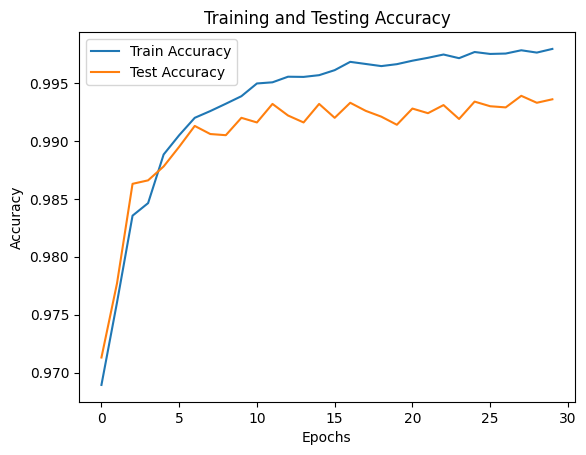

In [12]:
# Visualize the accuracy over epochs
plt.plot(range(30), train_acc_list, label='Train Accuracy')
plt.plot(range(30), test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy')
plt.show()

In [17]:
#学习率从0.001缩小为0.0003
#100层训练30次
for epoch in range(30):
  print('epoch:',epoch)
  train()
  test()

epoch: 0
Test acc: 0.9627
Train acc: 0.96015
epoch: 1
Test acc: 0.9702
Train acc: 0.9702833333333334
epoch: 2
Test acc: 0.9778
Train acc: 0.9767666666666667
epoch: 3
Test acc: 0.9814
Train acc: 0.9796333333333334
epoch: 4
Test acc: 0.9826
Train acc: 0.9820333333333333
epoch: 5
Test acc: 0.9858
Train acc: 0.9842
epoch: 6
Test acc: 0.9843
Train acc: 0.98455
epoch: 7
Test acc: 0.9873
Train acc: 0.9869666666666667
epoch: 8
Test acc: 0.9857
Train acc: 0.9884833333333334
epoch: 9
Test acc: 0.9873
Train acc: 0.98745
epoch: 10
Test acc: 0.9875
Train acc: 0.9890666666666666
epoch: 11
Test acc: 0.9888
Train acc: 0.9909666666666667
epoch: 12
Test acc: 0.9909
Train acc: 0.9915333333333334
epoch: 13
Test acc: 0.9894
Train acc: 0.9909833333333333
epoch: 14
Test acc: 0.9907
Train acc: 0.9922166666666666
epoch: 15
Test acc: 0.9906
Train acc: 0.9926166666666667
epoch: 16
Test acc: 0.9913
Train acc: 0.9930666666666667
epoch: 17
Test acc: 0.9917
Train acc: 0.9936166666666667
epoch: 18
Test acc: 0.9901
Tr

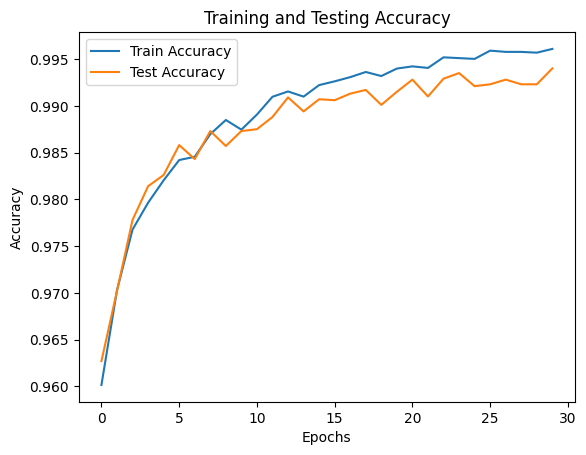

In [19]:
# Visualize the accuracy over epochs
plt.plot(range(30), train_acc_list, label='Train Accuracy')
plt.plot(range(30), test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy')
plt.show()

In [12]:
#学习率从0.001缩小为0.0003
#1000层训练20次
for epoch in range(30):
  print('epoch:',epoch)
  train()
  test()

epoch: 0
Test acc: 0.9868
Train acc: 0.9876
epoch: 1
Test acc: 0.9879
Train acc: 0.9891666666666666
epoch: 2
Test acc: 0.9883
Train acc: 0.9912833333333333
epoch: 3
Test acc: 0.991
Train acc: 0.99215
epoch: 4
Test acc: 0.9879
Train acc: 0.9924666666666667
epoch: 5
Test acc: 0.9892
Train acc: 0.9920333333333333
epoch: 6
Test acc: 0.991
Train acc: 0.99375
epoch: 7
Test acc: 0.9904
Train acc: 0.99325
epoch: 8
Test acc: 0.9925
Train acc: 0.9952833333333333
epoch: 9
Test acc: 0.9919
Train acc: 0.9953166666666666
epoch: 10
Test acc: 0.9927
Train acc: 0.9947666666666667
epoch: 11
Test acc: 0.9921
Train acc: 0.9959333333333333
epoch: 12
Test acc: 0.9927
Train acc: 0.9960833333333333
epoch: 13
Test acc: 0.9921
Train acc: 0.9960833333333333
epoch: 14
Test acc: 0.9921
Train acc: 0.9960166666666667
epoch: 15
Test acc: 0.993
Train acc: 0.9968833333333333
epoch: 16
Test acc: 0.9934
Train acc: 0.9969333333333333
epoch: 17
Test acc: 0.9932
Train acc: 0.9965666666666667
epoch: 18
Test acc: 0.9929
Train

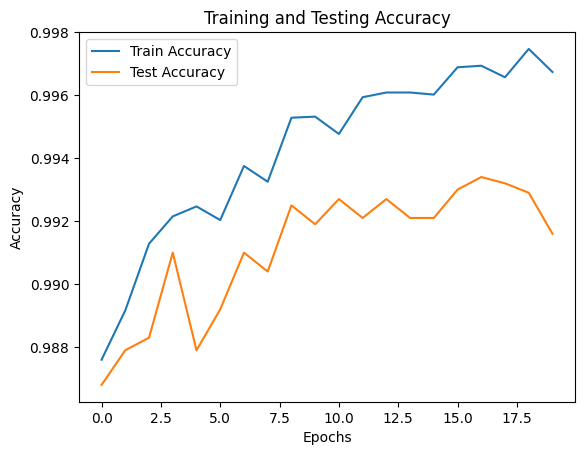

In [13]:
# Visualize the accuracy over epochs
plt.plot(range(20), train_acc_list, label='Train Accuracy')
plt.plot(range(20), test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy')
plt.show()

In [8]:
#学习率从0.001缩小为0.0003
#1000层训练30次
for epoch in range(30):
  print('epoch:',epoch)
  train()
  test()

epoch: 0
Test acc: 0.9744
Train acc: 0.9732666666666666
epoch: 1
Test acc: 0.9803
Train acc: 0.9805666666666667
epoch: 2
Test acc: 0.9846
Train acc: 0.9863833333333333
epoch: 3
Test acc: 0.9875
Train acc: 0.98905
epoch: 4
Test acc: 0.9869
Train acc: 0.98935
epoch: 5
Test acc: 0.9897
Train acc: 0.9906333333333334
epoch: 6
Test acc: 0.9915
Train acc: 0.99245
epoch: 7
Test acc: 0.9906
Train acc: 0.9932666666666666
epoch: 8
Test acc: 0.9902
Train acc: 0.9921333333333333
epoch: 9
Test acc: 0.9919
Train acc: 0.9946
epoch: 10
Test acc: 0.9913
Train acc: 0.9945833333333334
epoch: 11
Test acc: 0.9918
Train acc: 0.9945
epoch: 12
Test acc: 0.9915
Train acc: 0.9945333333333334
epoch: 13
Test acc: 0.992
Train acc: 0.9957
epoch: 14
Test acc: 0.9923
Train acc: 0.9959166666666667
epoch: 15
Test acc: 0.9935
Train acc: 0.9968666666666667
epoch: 16
Test acc: 0.9918
Train acc: 0.99635
epoch: 17
Test acc: 0.9925
Train acc: 0.9972833333333333
epoch: 18
Test acc: 0.9924
Train acc: 0.9967833333333334
epoch: 1

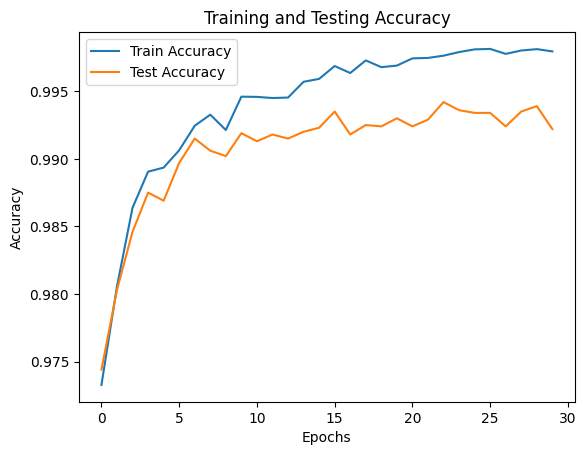

In [9]:
# Visualize the accuracy over epochs
plt.plot(range(30), train_acc_list, label='Train Accuracy')
plt.plot(range(30), test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy')
plt.show()

In [19]:
for epoch in range(30):
  print('epoch:',epoch)
  train()
  test()

epoch: 0
Test acc: 0.9727
Train acc: 0.9742166666666666
epoch: 1
Test acc: 0.9847
Train acc: 0.9855333333333334
epoch: 2
Test acc: 0.9892
Train acc: 0.9899333333333333
epoch: 3
Test acc: 0.9884
Train acc: 0.98915
epoch: 4
Test acc: 0.9884
Train acc: 0.9910166666666667
epoch: 5
Test acc: 0.9888
Train acc: 0.9914
epoch: 6
Test acc: 0.9852
Train acc: 0.9866833333333334
epoch: 7
Test acc: 0.9882
Train acc: 0.9908666666666667
epoch: 8
Test acc: 0.9899
Train acc: 0.9922166666666666
epoch: 9
Test acc: 0.9871
Train acc: 0.9909666666666667
epoch: 10
Test acc: 0.99
Train acc: 0.9935666666666667
epoch: 11
Test acc: 0.9902
Train acc: 0.9939166666666667
epoch: 12
Test acc: 0.99
Train acc: 0.9929166666666667
epoch: 13
Test acc: 0.9881
Train acc: 0.99125
epoch: 14
Test acc: 0.9883
Train acc: 0.9911666666666666
epoch: 15
Test acc: 0.9936
Train acc: 0.9953
epoch: 16
Test acc: 0.9929
Train acc: 0.9953333333333333
epoch: 17
Test acc: 0.9907
Train acc: 0.9953833333333333
epoch: 18
Test acc: 0.9913
Train a

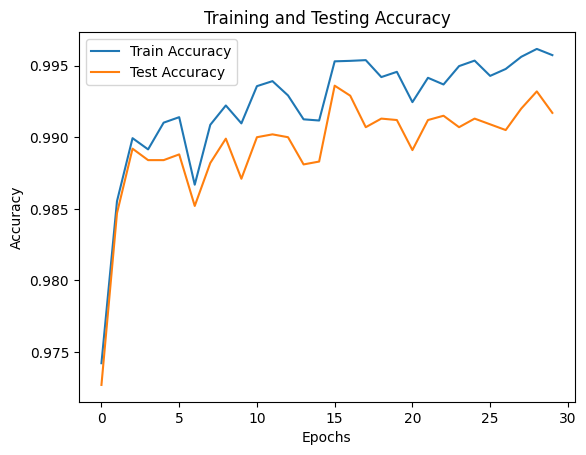

In [20]:
# Visualize the accuracy over epochs
plt.plot(range(30), train_acc_list, label='Train Accuracy')
plt.plot(range(30), test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy')
plt.show()

In [9]:
for epoch in range(30):
  print('epoch:',epoch)
  train()
  test()

epoch: 0
Test acc: 0.984
Train acc: 0.9834333333333334
epoch: 1
Test acc: 0.977
Train acc: 0.9762166666666666
epoch: 2
Test acc: 0.9811
Train acc: 0.9815
epoch: 3
Test acc: 0.9889
Train acc: 0.9891166666666666
epoch: 4
Test acc: 0.9851
Train acc: 0.9866666666666667
epoch: 5
Test acc: 0.9908
Train acc: 0.99095
epoch: 6
Test acc: 0.9877
Train acc: 0.9890166666666667
epoch: 7
Test acc: 0.9875
Train acc: 0.9883833333333333
epoch: 8
Test acc: 0.9871
Train acc: 0.9888333333333333
epoch: 9
Test acc: 0.9892
Train acc: 0.98965
epoch: 10
Test acc: 0.9923
Train acc: 0.9933166666666666
epoch: 11
Test acc: 0.9903
Train acc: 0.9922666666666666
epoch: 12
Test acc: 0.9891
Train acc: 0.9914333333333334
epoch: 13
Test acc: 0.9905
Train acc: 0.9934
epoch: 14
Test acc: 0.9907
Train acc: 0.9925
epoch: 15
Test acc: 0.9886
Train acc: 0.9906166666666667
epoch: 16
Test acc: 0.9892
Train acc: 0.9919333333333333
epoch: 17
Test acc: 0.9895
Train acc: 0.99165
epoch: 18
Test acc: 0.9923
Train acc: 0.9944
epoch: 19


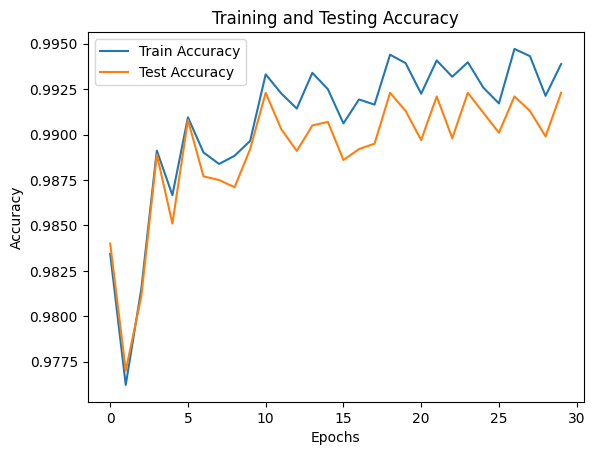

In [10]:
# Visualize the accuracy over epochs
plt.plot(range(30), train_acc_list, label='Train Accuracy')
plt.plot(range(30), test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy')
plt.show()

In [9]:
#提升学习率为0.0001
for epoch in range(30):
  print('epoch:',epoch)
  train()
  test()

epoch: 0
Test acc: 0.9853
Train acc: 0.9856333333333334
epoch: 1
Test acc: 0.9801
Train acc: 0.9786666666666667
epoch: 2
Test acc: 0.9857
Train acc: 0.98885
epoch: 3
Test acc: 0.9896
Train acc: 0.9924666666666667
epoch: 4
Test acc: 0.9908
Train acc: 0.9934833333333334
epoch: 5
Test acc: 0.9863
Train acc: 0.9899833333333333
epoch: 6
Test acc: 0.9927
Train acc: 0.9955166666666667
epoch: 7
Test acc: 0.9914
Train acc: 0.9949666666666667
epoch: 8
Test acc: 0.9927
Train acc: 0.9960833333333333
epoch: 9
Test acc: 0.9921
Train acc: 0.9944166666666666
epoch: 10
Test acc: 0.9898
Train acc: 0.9927166666666667
epoch: 11
Test acc: 0.9899
Train acc: 0.9937166666666667
epoch: 12
Test acc: 0.9927
Train acc: 0.99575
epoch: 13
Test acc: 0.9918
Train acc: 0.9950833333333333
epoch: 14
Test acc: 0.9927
Train acc: 0.9955
epoch: 15
Test acc: 0.9931
Train acc: 0.9965666666666667
epoch: 16
Test acc: 0.9918
Train acc: 0.9961
epoch: 17
Test acc: 0.9928
Train acc: 0.9969333333333333
epoch: 18
Test acc: 0.9916
Tra

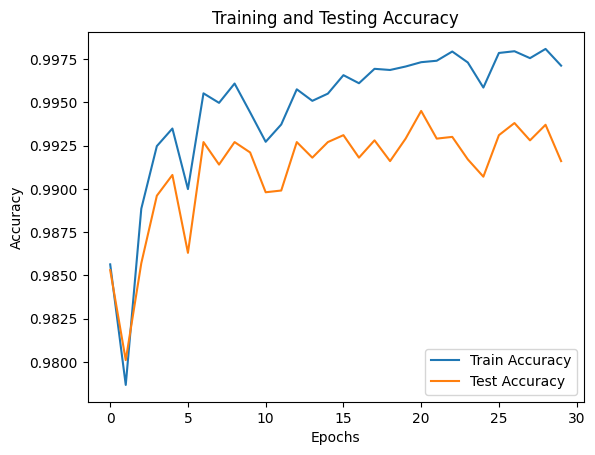

In [10]:
# Visualize the accuracy over epochs
plt.plot(range(30), train_acc_list, label='Train Accuracy')
plt.plot(range(30), test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy')
plt.show()